# "Interpretable and tractable models of transcriptional noise for the rational design of single-molecule quantification experiments"
## by Gennady Gorin<sup>*</sup>, John Vastola<sup>*</sup>, Meichen Fang, and Lior Pachter
### <sup>*</sup> These authors contributed equally to this work.
# Companion notebook for Figure 3 (alternate version)

This notebook is self-contained, and generates the panels used in the alternative version Figure 3a presented in the SI (albeit without axis labels). 

In [1]:
# Scientific computing imports
import numpy as np
from numpy.fft import irfftn
from numpy.random import choice
from scipy.stats import rv_discrete, poisson, nbinom, gaussian_kde
import matplotlib.pyplot as plt

# PyMC3-related imports
import pymc3 as pm
import theano.tensor as tt

# Plotting
import matplotlib.pyplot as plt
import arviz as az
import matplotlib as mpl

# Timer
import time as ti

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

------------------------------------------------

## Functions

### General-purpose functions

In [3]:
# Utility function that converts between (x, y) qualitative regime coordinates to original parameters.
def convert_xy_to_params(x, y, beta, gamma, K_avg):
    kappa = (beta + gamma)*(x/(1-x))
    a_over_th = 1/y - 1
    theta = np.sqrt(kappa*K_avg/a_over_th)
    a = K_avg*kappa/theta
    return a, kappa, theta


# Sample from flattened 2D probability distribution p. 
# mx = [mx0, mx1] is the shape of the 2D domain we're sampling.
def sample_from_p(mx, num_data_points, p_flat):
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')    # get grid of possible values
    x_choices = np.arange(np.prod(mx))                 # represent each grid point as a point in a 1D vector
    
    samples = choice(x_choices, size=num_data_points, replace=True, p=p_flat)
    d_N, d_M = X_N.flatten()[samples], X_M.flatten()[samples]    
    return d_N, d_M


# Get maximum of a 2D array
def get_2D_max(array):
    return np.unravel_index(array.argmax(), array.shape)


# Get KDE for smooth-looking heatmaps.
def get_2D_KDE(x_stats, y_stats, x_min=0, x_max=1, y_min=0, y_max=1):
    num_pts = 100                          # hyperparameter
    x_arg = np.linspace(x_min, x_max, num_pts)
    y_arg = np.linspace(y_min, y_max, num_pts)

    X_arg, Y_arg = np.meshgrid(x_arg, y_arg, indexing='ij')      # grid of points      X0, X1

 
    positions = np.vstack([X_arg.ravel(), Y_arg.ravel()])
    kernel = gaussian_kde([x_stats, y_stats])
    KDE = np.reshape(kernel(positions).T, X_arg.shape)
    return KDE, x_arg, y_arg
    

### Trivial model (constitutive/Poisson and mixture/NB) likelihood functions

In [4]:
# Constitutive model likelihood function.
def get_Poiss_2sp(mx, params):
    beta, gamma, a, kappa, theta = params 
    K_avg = (a*theta)/kappa
    mu_N, mu_M = K_avg/beta, K_avg/gamma
    
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')
    
    return poisson.pmf(X_N, mu_N)*poisson.pmf(X_M, mu_M)


# Mixture model likelihood function.
def get_NB_2sp(mx, params):
    beta, gamma, a, kappa, theta = params 
    
    # Get generating function argument
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    gf = np.exp(- (a/kappa)*np.log(1 - theta*(g[0]/beta + g[1]/gamma)))
    gf = gf.reshape(tuple(half))
                              
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss

### $\Gamma$-OU likelihood functions

In [5]:
# Get 2 species GOU generating function using ODE method
def get_gf_GOU_2sp_ODE(g0, g1, params):
    beta_0, beta_1, a, kappa, theta = params     # get parameters
    
    c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g1)   
    
    min_fudge, max_fudge = 0.25, 10                                     # Determine integration time scale / length
    dt = np.min([1/kappa, 1/theta, 1/a, 1/beta_0, 1/beta_1])*min_fudge
    t_max = np.max([1/kappa, 1/theta, 1/a, 1/beta_0, 1/beta_1])*max_fudge
    num_tsteps = int(np.ceil(t_max/dt))
    t_array = np.linspace(0, t_max, num_tsteps+1)
    t_array = t_array.reshape((1, num_tsteps + 1))
    
    q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    c0 = c0.reshape((c0.shape[0],1))
    c1 = c1.reshape((c1.shape[0],1))
    q0 = theta*c0*(np.exp(-beta_0*t_array) - np.exp(-kappa*t_array))/(kappa - beta_0) 
    q1 = theta*c1*(np.exp(-beta_1*t_array) - np.exp(-kappa*t_array))/(kappa - beta_1)
    q = q0 + q1
    

    integrand = q/(1-q)
    integral = np.trapz(integrand, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp( a*integral)               # get generating function
    return gf


# Get Pss for 2 species GOU model via ODE method
def get_GOU_2sp(mx, params):
    # Get generating function argument
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    gf = get_gf_GOU_2sp_ODE(g[0], g[1], params)                    
    gf = gf.reshape(tuple(half))
    
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss


# Log likelihood of GOU model given data. Uses (x,y) as input instead of (kappa, theta).
def ll_GOU(phi, const, mx, data):
    # Get parameters
    x, y = phi
    beta, gamma, K_avg = const
    
    # Convert from (x, y) to original parameters
    a, kappa, theta = convert_xy_to_params(x, y, beta, gamma, K_avg)
    params = [beta, gamma, a, kappa, theta]
    
    Pss = get_GOU_2sp(mx, params)    # Compute Pss

    lp = np.log(Pss)
    result = np.sum(lp[tuple(data)])
    return result


# Combines the above functions into one to reduce overhead associated with Python function calls.
# Helpful when doing expensive posterior sampling (since many likelihood function calls are required).
def ll_GOU2(phi, const, mx, data):
    # Get parameters
    x, y = phi
    beta, gamma, K_avg = const
    
    
    # Convert from (x, y) to original parameters
    a, kappa, theta = convert_xy_to_params(x, y, beta, gamma, K_avg)
    params = [beta, gamma, a, kappa, theta]
    
    
    # Get generating function argument
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    beta_0 = beta
    beta_1 = gamma
    
    c0 = (g[0]) + (beta_0/(beta_1 - beta_0))*(g[1])       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g[1])   
    
    min_fudge, max_fudge = 0.5, 10                                     # Determine integration time scale / length
    dt = np.min([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*min_fudge
    t_max = np.max([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*max_fudge
    num_tsteps = int(np.ceil(t_max/dt))
    
    t_array = np.linspace(0, t_max, num_tsteps+1)
    t_array = t_array.reshape((1, num_tsteps + 1))
    
    q = np.zeros((c0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    c0 = c0.reshape((c0.shape[0],1))
    c1 = c1.reshape((c1.shape[0],1))
    q0 = theta*c0*(np.exp(-beta_0*t_array) - np.exp(-kappa*t_array))/(kappa - beta_0) 
    q1 = theta*c1*(np.exp(-beta_1*t_array) - np.exp(-kappa*t_array))/(kappa - beta_1)
    q = q0 + q1

    integrand = q/(1-q)
    integral = np.trapz(integrand, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp( a*integral)               # get generating function
    
    gf = gf.reshape(tuple(half))
    
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize

    lp = np.log(Pss)
    result = np.sum(lp[tuple(data)])
    return result

### CIR likelihood functions

In [6]:
# ODE for 2 species CIR model
def f_2sp(q, t, c0, c1, params):
    beta_0, beta_1, a, kappa, theta = params
    result = - kappa*q + theta*q*q + kappa*( c0*np.exp(-beta_0*t) + c1*np.exp(-beta_1*t)  ) 
    return result


# Vectorized RK4 implementation for 2 species CIR model
def RK4_2sp(q, f, t, c0, c1, step_size, param):
    j1 = f(q, t, c0, c1, param)
    j2 = f(q + (step_size/2)*j1, t + (step_size/2), c0, c1, param)   
    j3 = f(q + (step_size/2)*j2, t + (step_size/2), c0, c1, param)   
    j4 = f(q + (step_size)*j3, t + (step_size), c0, c1, param)  
    
    q_new = q + (step_size/6)*(j1 + 2*j2 + 2*j3 + j4)
    return q_new


# Get 2 species CIR generating function using ODE method
def get_gf_CIR_2sp(g0, g1, params):
    beta_0, beta_1, a, kappa, theta = params     # get parameters
    
    c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g1)   
    
    min_fudge, max_fudge = 0.25, 10                                     # Determine integration time scale / length
    dt = np.min([1/kappa, 1/theta, 1/a, 1/beta_0, 1/beta_1])*min_fudge
    t_max = np.max([1/kappa, 1/theta, 1/a, 1/beta_0, 1/beta_1])*max_fudge
    num_tsteps = int(np.ceil(t_max/dt))
     
    q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    
    # Solve ODE using RK4 method 
    for i in range(0, num_tsteps):
        t = i*dt
        q[:,i+1] = RK4_2sp(q[:,i], f_2sp, t, c0, c1, dt, params)
        
    integral = np.trapz(q, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp((a*theta/kappa)*integral)               # get generating function
    return gf


# Get Pss for 2 species CIR model via ODE method
def get_CIR_2sp(mx, params):
    # Get generating function argument
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    gf = get_gf_CIR_2sp(g[0], g[1], params)                    
    gf = gf.reshape(tuple(half))
                              
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss


# Log likelihood of CIR model given data. Uses (x,y) as input instead of (kappa, theta).
def ll_CIR(phi, const, mx, data):
    # Get parameters
    x, y = phi
    beta, gamma, K_avg = const
    
    # Convert from (x, y) to original parameters
    a, kappa, theta = convert_xy_to_params(x, y, beta, gamma, K_avg)
    params = [beta, gamma, a, kappa, theta]
    
    Pss = get_CIR_2sp(mx, params)    # Compute Pss

    lp = np.log(Pss)
    result = np.sum(lp[data])
    return result

### Bayes factor functions

In [7]:
# Generates synthetic data (either CIR or GOU) and computes log Bayes factor (e.g. P(CIR)/P(GOU))).
# Does this averaged over many trials (num_trials).
# Does this assuming different numbers of data points (e.g. num_data_points = [100, 200, 1000]). 
def log_bayes_factor_avg(model, num_data_points, num_trials, mx, params):
    
    # Initialize log BF arrays 
    num_kinds = len(num_data_points) 
    log_bf_joint = np.zeros((num_kinds, num_trials))
    log_bf_nascent = np.zeros((num_kinds, num_trials))
    log_bf_mature = np.zeros((num_kinds, num_trials))
    
    # Get Pss for each model given this parameter set
    if model=='CIR':
        pss = get_CIR_2sp(mx, params)
        pss_other = get_GOU_2sp(mx, params)
    elif model=='GOU':
        pss = get_GOU_2sp(mx, params)
        pss_other = get_CIR_2sp(mx, params)
    p_flat = pss.flatten()
    
    
    

    # Log-likelihood functions
    lp = np.log10(pss)    # shape: x_N_domain by x_M_domain
    lp_nascent = np.log10(np.sum(pss, axis=1))
    lp_mature = np.log10(np.sum(pss, axis=0))

    lp_other = np.log10(pss_other)
    lp_other_nascent = np.log10(np.sum(pss_other, axis=1))
    lp_other_mature = np.log10(np.sum(pss_other, axis=0))
    
    

    
    # Get fake data
    for r in range(0, num_kinds):
            
        # Sample nascent and mature counts
        d_N, d_M = sample_from_p(mx, (num_data_points[r], num_trials), p_flat)

        # Log-likelihoods given data
        ll_joint = np.sum(lp[d_N, d_M], axis=0)
        ll_nascent = np.sum(lp_nascent[d_N], axis=0)
        ll_mature = np.sum(lp_mature[d_M], axis=0)

        ll_other_joint = np.sum(lp_other[d_N, d_M], axis=0)
        ll_other_nascent = np.sum(lp_other_nascent[d_N], axis=0) 
        ll_other_mature = np.sum(lp_other_mature[d_M], axis=0)

        # Bayes factor
        log_bf_joint[r,:] = ll_joint - ll_other_joint
        log_bf_nascent[r,:] = ll_nascent - ll_other_nascent
        log_bf_mature[r,:] = ll_mature - ll_other_mature

                          
    log_bf_joint_avg = np.mean(log_bf_joint, axis=1)
    log_bf_nascent_avg = np.mean(log_bf_nascent, axis=1)
    log_bf_mature_avg = np.mean(log_bf_mature, axis=1)
    
    return log_bf_joint_avg, log_bf_nascent_avg, log_bf_mature_avg

------------------------------------------

## Log Bayes factors across space of qualitative regimes

Define a function that does everything. Will run this multiple times.

In [10]:
def get_BF_plot(name, model, K_avg, beta, gamma, mx):


    # Hyperparameters
    num_data_points = np.array([100, 200, 1000, 5000])     # do everything assuming we have _ cells (e.g. 100)
    num_kinds = len(num_data_points)
    num_trials = 100    # for a given parameter set, how many fake data sets to average over


    # Set up qualitative regimes grid
    x_min, x_max, num_x = 0.1, 0.9, 10
    y_min, y_max, num_y = 0.1, 0.9, 10
    x, y = np.linspace(x_min, x_max, num_x), np.linspace(y_min, y_max, num_y)
    X, Y = np.meshgrid(x, y, indexing='ij')

    a, kappa, theta = convert_xy_to_params(X, Y, beta, gamma, K_avg)   # values of other params at each grid point


    # Output arrays
    log_bf_joint = np.zeros((num_kinds, num_x, num_y))
    log_bf_nascent = np.zeros((num_kinds, num_x, num_y))
    log_bf_mature = np.zeros((num_kinds, num_x, num_y))
    
    
    # Compute log Bayes factors
    start_time = ti.time()
    print("Computing log Bayes factors on a ", num_x, " x ", num_y, " grid...")
    for i in range(0, num_x):
        print("Row ", i+1, "/", num_x, "...")
        for j in range(0, num_y):
            params = [beta, gamma, a[i,j], kappa[i,j], theta[i,j]]   # parameters for this grid point

            log_bf_joint[:,i, j], log_bf_nascent[:,i, j], log_bf_mature[:,i, j] = (
                                log_bayes_factor_avg(model, num_data_points, num_trials, mx, params) )


    print("--- %s seconds ---" % (ti.time() - start_time))
    
    
    
    # Plot results
    
    # Clip arrays before plotting. Lower bound: 0 (no evidence either way), upper bound: 2 (decisive evidence).
    bf_min, bf_max = 0, 2

    for r in range(0, num_kinds):
        gs_kw = dict(hspace=-0.37, wspace=0, width_ratios=[1,1,1])
        fig, axs = plt.subplots(1,3, sharey=True, sharex=True, squeeze=True, gridspec_kw=gs_kw)

        (ax1, ax2, ax3) = axs

        ax1.imshow(np.transpose(log_bf_joint[r,:,:]), origin='lower', extent=[x_min, x_max, y_min, y_max], vmin = bf_min, vmax = bf_max)
        ax2.imshow(np.transpose(log_bf_nascent[r,:,:]), origin='lower', extent=[x_min, x_max, y_min, y_max], vmin = bf_min, vmax = bf_max)
        ax3.imshow(np.transpose(log_bf_mature[r,:,:]), origin='lower', extent=[x_min, x_max, y_min, y_max], vmin = bf_min, vmax = bf_max)

        plt.savefig('results/'+name+str(num_data_points[r])+'c.png', bbox_inches='tight')
        plt.savefig('results/'+name+str(num_data_points[r])+'c.pdf', bbox_inches='tight')
        plt.show()


    #####
    
    
    return

----------------------------------------------------

Computing log Bayes factors on a  10  x  10  grid...
Row  1 / 10 ...
Row  2 / 10 ...
Row  3 / 10 ...
Row  4 / 10 ...
Row  5 / 10 ...
Row  6 / 10 ...
Row  7 / 10 ...
Row  8 / 10 ...
Row  9 / 10 ...
Row  10 / 10 ...
--- 10.5771005153656 seconds ---


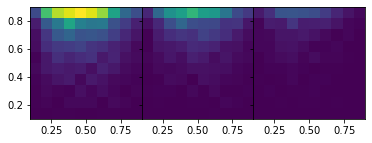

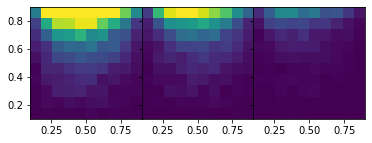

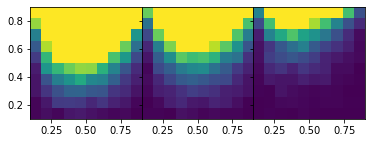

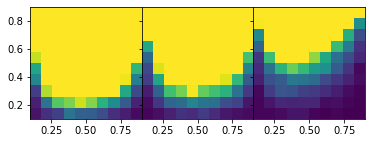

In [11]:
name = "same_but_GOU_data"
model = "GOU"
mx = [30, 30]    # get prob dist for this domain ; bigger = more accurate
K_avg = 5
beta, gamma = 1, 1.5

get_BF_plot(name, model, K_avg, beta, gamma, mx)

Computing log Bayes factors on a  10  x  10  grid...
Row  1 / 10 ...


<ipython-input-7-0aa11ad1c9c5>:29: RuntimeWarning: divide by zero encountered in log10
  lp_other = np.log10(pss_other)


Row  2 / 10 ...
Row  3 / 10 ...
Row  4 / 10 ...
Row  5 / 10 ...
Row  6 / 10 ...
Row  7 / 10 ...
Row  8 / 10 ...
Row  9 / 10 ...
Row  10 / 10 ...
--- 92.30604004859924 seconds ---


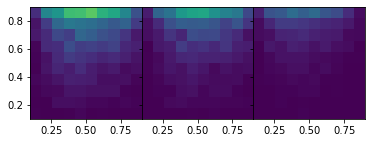

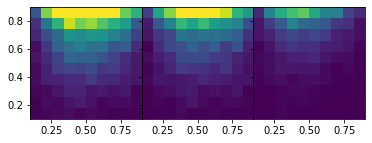

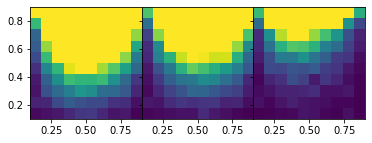

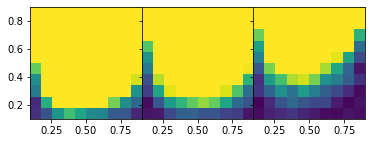

In [13]:
name = "same_but_larger_mean"
model = "CIR"
mx = [120, 120]    # get prob dist for this domain ; bigger = more accurate
K_avg = 20
beta, gamma = 1, 1.5

get_BF_plot(name, model, K_avg, beta, gamma, mx)

Computing log Bayes factors on a  10  x  10  grid...
Row  1 / 10 ...
Row  2 / 10 ...
Row  3 / 10 ...
Row  4 / 10 ...
Row  5 / 10 ...
Row  6 / 10 ...
Row  7 / 10 ...
Row  8 / 10 ...
Row  9 / 10 ...
Row  10 / 10 ...
--- 11.113316774368286 seconds ---


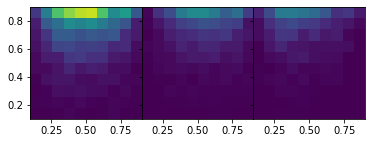

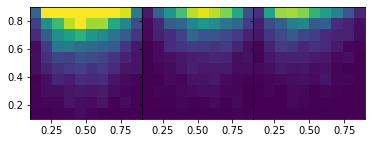

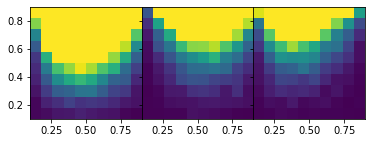

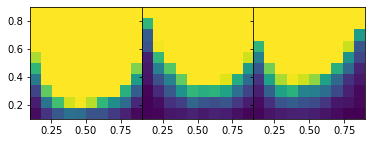

In [14]:
name = "same_but_beta_bigger"
model = "CIR"
mx = [30, 30]    # get prob dist for this domain ; bigger = more accurate
K_avg = 5
beta, gamma = 1.5, 1

get_BF_plot(name, model, K_avg, beta, gamma, mx)